# neural time step evolution/generating histograms and time series data 
Tim Tyree<br>
12.9.2020<br>

In [11]:
%matplotlib inline
from lib.my_initialization import *
from lib.controller.integrate_forward_dormand_prince_asynchronous import *
from lib.controller.one_step_forward_euler import *
from lib.controller.simple_explicit_time_adaptation import *

%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# # import os, re, sys, matplotlib.pyplot as plt, numpy as np, pandas as pd
# from tkinter import filedialog, Tk
# # from glob import glob
# def search_for_file (currdir = os.getcwd()):
# 	'''#make functions for save file name, input cell frames, and input cell trajectories'''
# 	#TODO: eventually make this ^take cell trajectories or cell positions
# 	root = Tk()
# 	tempdir = filedialog.askopenfilename(parent=root, 
# 										 initialdir=currdir, 
# 										 title="Please select a file")#, 
# 										 # filetypes = (("all files","*.*")))
# 	root.destroy()
# 	if len(tempdir) > 0:
# 		print ("File: %s" % tempdir)
# 	return tempdir

# scratch

In [13]:
# data_folder = nb_dir + '/../data/mov_csv/'
# os.chdir(data_folder)

In [14]:
# !ls

In [15]:
# # input_count_fn = 'avi_ns_counts_spherical_mesh_100_mu_1.0_lambda_10.0_gamma_0.0.npy.npz'
# # input_csv_fn = 'avi_ns_spherical_mesh_100_mu_1.0_lambda_10.0_gamma_0.0.csv'
# input_count_fn = "avi_ns_counts_spherical_mesh_100_mu_1.0_lambda_10.0_gamma_0.0.npz"
# input_csv_fn = "avi_ns_spherical_mesh_100_mu_1.0_lambda_10.0_gamma_0.0.csv"

## (not working) view a video

In [16]:
# vid_folder = nb_dir + '/../vid'
# os.chdir(vid_folder)
# vid_fn = "/Users/timothytyree/Documents/GitHub/avi/vid/out.mp4"#search_for_file ()
# # vid_fn_avi = vid_fn.replace('.mov','.avi')
# print(vid_fn)

In [17]:
# !ffmpeg f"{vid_fn}" f"{vid_fn_avi}"
# !ffmpeg -i vid_fn vid_fn_avi
# !ls -l


In [18]:
# # from IPython.display import Video

# # Video(vid_fn)
# # # Video('out.webm')

# from IPython.display import HTML

# # HTML(f"""
# #     <video alt="test" controls>
# #         <source src="{os.path.basename(vid_fn)}" type="video/mp4">
# #     </video>
# # """)

# # HTML(f"""
# # <video width="320" height="240" controls>
# #   <source src="{os.path.basename(vid_fn)}" type="video/mp4">
# # </video>
# # """)

## plot measures 

In [19]:
# df = pd.read_csv(input_csv_fn)

# x_values = df['t'].values
# # y_values = df['volume'].values
# # y_values = df['energy'].values
# plt.plot(x_values, df['volume'].values/(4*np.pi*1.**3/3), label='volume/initial volume')
# plt.plot(x_values, df['energy'].values, label='energy')
# plt.legend()
# plt.xlabel('time')
# plt.ylabel('measurement value')
# plt.show()

# x_values = df['t'].values
# # y_values = df['volume'].values
# # y_values = df['energy'].values
# plt.title('neural time steps evolve in time')
# plt.plot(x_values, df['stepsize_mean'].values, label='mean stepsize')
# plt.plot(x_values, df['stepsize_median'].values, label='median stepsize')
# plt.legend()
# plt.xlabel('time')
# plt.ylabel('step size')
# plt.yscale('log')
# plt.yticks([10**-4,10**-2])
# plt.show()

# df['stepsize_std'].values

# os.chdir(data_folder)
# element_array_stepsize_array = np.load(input_count_fn)

# element_array_stepsize_array

# plt.hist(element_array_stepsize_array[0][-1])
# plt.show()

## import mesh

In [77]:
#define Lamé parameters
mu = 1.; lam = 10.; 
#define coefficient for Rayleigh damping
gamma = .05#1.#1.;

#define adaptive time stepping absolute tolerances
salience = 2#128#32
learning_rate = np.log(salience) #np.log(16) #np.log(2)
lasso_fraction = 0.5
v_scale = 2.
mass_density=1.

stepsize_init = 0.0001#0.0001
atol_x = 0.0000001#0.001#1e-7; 
atol_v = 0.0000001#0.001#1e-7; 
btol_x = 0.00000001#0.001#1e-10; 
btol_v = 0.00000001#0.001#1e-10; 


#path to mesh
input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'
#where to save results
data_folder =  os.path.join(nb_dir,'../data/mov_csv')
data_fn = f"avi_es_fixed_lr_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}_vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
# data_fn = f"avi_ns_fixed_lr_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
save_folder_vid = '../vid/tmp'
folder_vid = '../vid'
# data_fn_counts = data_fn.replace("s_","s_counts_").replace('.csv','.npz')
data_fn_counts = data_fn.replace("s_","s_counts_").replace('.csv','.npy')

os.chdir(nb_dir)
# input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'
# input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'
input_file_name = os.path.join(nb_dir,input_file_name)
tme = 0.
dict_values_system = initialize_system(input_file_name, time_initial=tme, mass_density=mass_density)
locals().update(dict_values_system)
N_elements = element_array_index.shape[0]
N_vertices = node_array_position.shape[0]
print(list(dict_values_system.keys()))

#header to start of video
# TEXT = '''TEXT=$'Synchronous Variational Integrator\nDamped Neohookean Model\n(inward squish)''''
TEXT = f"""
TEXT=$'an inward squish
        Asynchronous Variational Integrator 
        Dormand–Prince Method
        
        Undamped Neohookean Model
        mu {mu}  lambda {lam} gamma {gamma}
        
        Spherical Mesh
        Num. Vertices {N_vertices}
        Num. Elements {N_elements}
'"""


# TEXT = f"""
# TEXT=$'an inward squish with neural time steps
#         Asynchronous Variational Integrator 
#         Dormand–Prince Method
        
#         Undamped Neohookean Model
#         mu {mu}  lambda {lam} gamma {gamma}
        
#         Spherical Mesh
#         Num. Vertices {N_vertices}
#         Num. Elements {N_elements}
# '"""

#write header to file
# print(TEXT)
# Dormand–Prince Method
# Explicit Newmark Method
# Implicit Midpoint Rule

face_normals all zero, ignoring!


['element_array_time', 'element_array_index', 'element_array_mass', 'element_array_volume', 'element_array_inverse_equilibrium_position', 'node_array_equilibrium_position', 'node_array_time', 'node_array_position', 'node_array_momentum', 'node_array_mass', 'node_array_volume']


## initialize
- Mesh = solid sphere discretized by tetrahedra 
- Forces = neohookean hyperelastic material with rayleigh damping
- Initialization = inward initial velocity by an amount proportional to the x coordinate.

In [78]:
#initialize system
tauK = element_array_time
tau = node_array_time

#get method of computing elastic forces 
zero_mat = np.zeros((4,3))
# calc_P = get_calc_P(mu, lam)
# compute_nodal_damping_forces  = get_compute_nodal_damping_forces(mu,lam,gamma)
# comp_nodal_elastic_forces = get_comp_nodal_elastic_forces(mu, lam)

elements = element_array_index
vertices = node_array_position

#initialize stepsizes of simulation
element_array_stepsize = np.zeros_like(element_array_time) + stepsize_init
element_array_count_calls_one_step = np.zeros_like(element_array_time,dtype=int)
element_array_count_config_updates = np.zeros_like(element_array_time,dtype=int)
momentum = node_array_momentum.copy()
velocities = momentum.copy()
for j in range(N_vertices):
    velocities[j] /= node_array_mass[j]


# #perturb momentum in the x direction and let it run overnight with a small timestep  
velocities[:,0] = -v_scale * vertices[:,0].copy()

#initialize containers of measures
volume_lst = []
energy_lst = []
tme_lst    = []
stepsize_mean_lst   = []
stepsize_std_lst    = []
stepsize_median_lst = []
stepsize_count_lst = []
frac_lb = lambda i: np.exp(learning_rate*i)  ##np.exp((i+.5)*learning_rate/10)
learning_bins = np.array([stepsize_init*frac_lb(i) for i in np.arange(-15,15)])

# #this looks nice. 30 bins
# learning_bins = np.array([0.00480198, 0.00480886, 0.00481574, 0.00482262, 0.00482951,
#         0.00483639, 0.00484327, 0.00485015, 0.00485703, 0.00486391,
#         0.0048708 , 0.00487768, 0.00488456, 0.00489144, 0.00489832,
#         0.0049052 , 0.00491209, 0.00491897, 0.00492585, 0.00493273,
#         0.00493961, 0.00494649, 0.00495338, 0.00496026, 0.00496714,
#         0.00497402, 0.0049809 , 0.00498778, 0.00499467, 0.00500155,
#         0.00500843])

# #let's try 100 bins
# learning_bins = np.array([0.00477609, 0.00477838, 0.00478067, 0.00478296, 0.00478526,
#         0.00478755, 0.00478984, 0.00479214, 0.00479443, 0.00479672,
#         0.00479902, 0.00480131, 0.0048036 , 0.0048059 , 0.00480819,
#         0.00481048, 0.00481277, 0.00481507, 0.00481736, 0.00481965,
#         0.00482195, 0.00482424, 0.00482653, 0.00482883, 0.00483112,
#         0.00483341, 0.00483571, 0.004838  , 0.00484029, 0.00484258,
#         0.00484488, 0.00484717, 0.00484946, 0.00485176, 0.00485405,
#         0.00485634, 0.00485864, 0.00486093, 0.00486322, 0.00486552,
#         0.00486781, 0.0048701 , 0.0048724 , 0.00487469, 0.00487698,
#         0.00487927, 0.00488157, 0.00488386, 0.00488615, 0.00488845,
#         0.00489074, 0.00489303, 0.00489533, 0.00489762, 0.00489991,
#         0.00490221, 0.0049045 , 0.00490679, 0.00490908, 0.00491138,
#         0.00491367, 0.00491596, 0.00491826, 0.00492055, 0.00492284,
#         0.00492514, 0.00492743, 0.00492972, 0.00493202, 0.00493431,
#         0.0049366 , 0.0049389 , 0.00494119, 0.00494348, 0.00494577,
#         0.00494807, 0.00495036, 0.00495265, 0.00495495, 0.00495724,
#         0.00495953, 0.00496183, 0.00496412, 0.00496641, 0.00496871,
#         0.004971  , 0.00497329, 0.00497558, 0.00497788, 0.00498017,
#         0.00498246, 0.00498476, 0.00498705, 0.00498934, 0.00499164,
#         0.00499393, 0.00499622, 0.00499852, 0.00500081, 0.0050031 ,
#         0.00500539])

# learning_bins = np.array([stepsize_init*np.exp((i+.5)*learning_rate) for i in np.arange(-3,3)])
print(f"learning_bins are {learning_bins}")

learning_bins are [3.05175781e-09 6.10351563e-09 1.22070313e-08 2.44140625e-08
 4.88281250e-08 9.76562500e-08 1.95312500e-07 3.90625000e-07
 7.81250000e-07 1.56250000e-06 3.12500000e-06 6.25000000e-06
 1.25000000e-05 2.50000000e-05 5.00000000e-05 1.00000000e-04
 2.00000000e-04 4.00000000e-04 8.00000000e-04 1.60000000e-03
 3.20000000e-03 6.40000000e-03 1.28000000e-02 2.56000000e-02
 5.12000000e-02 1.02400000e-01 2.04800000e-01 4.09600000e-01
 8.19200000e-01 1.63840000e+00]


# generate a series of histograms with spreading out time steps using simple time adaptation

## initialize

In [79]:
# #define Lamé parameters
# mu = 1.; lam = 10.; 
# #define coefficient for Rayleigh damping
# gamma = .05#1.#1.;

# #define adaptive time stepping absolute tolerances
# salience = 2#128#32
# learning_rate = np.log(salience) #np.log(16) #np.log(2)
# lasso_fraction = 0.5
# v_scale = 2.
# mass_density=1.

# stepsize_init = 0.002#0.005#0.00001#0.0001
# atol_x = 0.00001#0.001#1e-7; 
# atol_v = 0.00001#0.001#1e-7; 
# btol_x = 0.000001#0.001#1e-10; 
# btol_v = 0.000001#0.001#1e-10; 
# # element volume versus equilibrium step size

# #path to mesh
# input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'
# # input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'

# # input_file_name = f'../data/spherical_meshes/spherical_mesh_400.stl'
# #where to save results
# data_folder =  os.path.join(nb_dir,'../data/mov_csv')
# data_fn = f"avi_es_fixed_lr_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}_vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
# # data_fn = f"avi_ns_fixed_lr_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
# save_folder_vid = '../vid/tmp'
# folder_vid = '../vid'
# # data_fn_counts = data_fn.replace("s_","s_counts_").replace('.csv','.npz')
# data_fn_counts = data_fn.replace("s_","s_counts_").replace('.csv','.npy')

# os.chdir(nb_dir)
# # input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'
# # input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'
# input_file_name = os.path.join(nb_dir,input_file_name)
# tme = 0.
# dict_values_system = initialize_system(input_file_name, time_initial=tme, mass_density=mass_density)
# locals().update(dict_values_system)
# N_elements = element_array_index.shape[0]
# N_vertices = node_array_position.shape[0]
# print(list(dict_values_system.keys()))

# #header to start of video
# # TEXT = '''TEXT=$'Synchronous Variational Integrator\nDamped Neohookean Model\n(inward squish)''''
# TEXT = f"""
# TEXT=$'an inward squish
#         Asynchronous Variational Integrator 
#         Explicit Newmark Method
        
#         Undamped Neohookean Model
#         mu {mu}  lambda {lam} gamma {gamma}
        
#         Spherical Mesh
#         Num. Vertices {N_vertices}
#         Num. Elements {N_elements}
# '"""


# # TEXT = f"""
# # TEXT=$'an inward squish with neural time steps
# #         Asynchronous Variational Integrator 
# #         Dormand–Prince Method
        
# #         Undamped Neohookean Model
# #         mu {mu}  lambda {lam} gamma {gamma}
        
# #         Spherical Mesh
# #         Num. Vertices {N_vertices}
# #         Num. Elements {N_elements}
# # '"""

# #write header to file
# # print(TEXT)
# # Dormand–Prince Method
# # Explicit Newmark Method
# # Implicit Midpoint Rule

In [80]:
# integrate_system_explicit_asynchronous = get_integrate_system_explicit_asynchronous(mu,lam,gamma)

# mode = 'neural_lr'



integrate_system_dormand_prince_asynchronous = get_integrate_system_dormand_prince_asynchronous(mu,lam,gamma,atol_x, atol_v, btol_x, btol_v,learning_rate, lasso_fraction)

integrate_system = integrate_system_dormand_prince_asynchronous

In [81]:
#initialize system
tauK = element_array_time
tau = node_array_time

#get method of computing elastic forces 
zero_mat = np.zeros((4,3))
# calc_P = get_calc_P(mu, lam)
# compute_nodal_damping_forces  = get_compute_nodal_damping_forces(mu,lam,gamma)
# comp_nodal_elastic_forces = get_comp_nodal_elastic_forces(mu, lam)

elements = element_array_index
vertices = node_array_position

#initialize stepsizes of simulation
element_array_stepsize = np.zeros_like(element_array_time) + stepsize_init
element_array_count_calls_one_step = np.zeros_like(element_array_time,dtype=int)
element_array_count_config_updates = np.zeros_like(element_array_time,dtype=int)
momentum = node_array_momentum.copy()
velocities = momentum.copy()
for j in range(N_vertices):
    velocities[j] /= node_array_mass[j]


# #perturb momentum in the x direction and let it run overnight with a small timestep  
velocities[:,0] = -v_scale * vertices[:,0].copy()

#initialize containers of measures
volume_lst = []
energy_lst = []
tme_lst    = []
stepsize_mean_lst   = []
stepsize_std_lst    = []
stepsize_median_lst = []
stepsize_count_lst = []
frac_lb = lambda i: np.exp(learning_rate*i)  ##np.exp((i+.5)*learning_rate/10)
learning_bins = np.array([stepsize_init*frac_lb(i) for i in np.arange(-15,15)])

# #this looks nice. 30 bins
# learning_bins = np.array([0.00480198, 0.00480886, 0.00481574, 0.00482262, 0.00482951,
#         0.00483639, 0.00484327, 0.00485015, 0.00485703, 0.00486391,
#         0.0048708 , 0.00487768, 0.00488456, 0.00489144, 0.00489832,
#         0.0049052 , 0.00491209, 0.00491897, 0.00492585, 0.00493273,
#         0.00493961, 0.00494649, 0.00495338, 0.00496026, 0.00496714,
#         0.00497402, 0.0049809 , 0.00498778, 0.00499467, 0.00500155,
#         0.00500843])

# #let's try 100 bins
# learning_bins = np.array([0.00477609, 0.00477838, 0.00478067, 0.00478296, 0.00478526,
#         0.00478755, 0.00478984, 0.00479214, 0.00479443, 0.00479672,
#         0.00479902, 0.00480131, 0.0048036 , 0.0048059 , 0.00480819,
#         0.00481048, 0.00481277, 0.00481507, 0.00481736, 0.00481965,
#         0.00482195, 0.00482424, 0.00482653, 0.00482883, 0.00483112,
#         0.00483341, 0.00483571, 0.004838  , 0.00484029, 0.00484258,
#         0.00484488, 0.00484717, 0.00484946, 0.00485176, 0.00485405,
#         0.00485634, 0.00485864, 0.00486093, 0.00486322, 0.00486552,
#         0.00486781, 0.0048701 , 0.0048724 , 0.00487469, 0.00487698,
#         0.00487927, 0.00488157, 0.00488386, 0.00488615, 0.00488845,
#         0.00489074, 0.00489303, 0.00489533, 0.00489762, 0.00489991,
#         0.00490221, 0.0049045 , 0.00490679, 0.00490908, 0.00491138,
#         0.00491367, 0.00491596, 0.00491826, 0.00492055, 0.00492284,
#         0.00492514, 0.00492743, 0.00492972, 0.00493202, 0.00493431,
#         0.0049366 , 0.0049389 , 0.00494119, 0.00494348, 0.00494577,
#         0.00494807, 0.00495036, 0.00495265, 0.00495495, 0.00495724,
#         0.00495953, 0.00496183, 0.00496412, 0.00496641, 0.00496871,
#         0.004971  , 0.00497329, 0.00497558, 0.00497788, 0.00498017,
#         0.00498246, 0.00498476, 0.00498705, 0.00498934, 0.00499164,
#         0.00499393, 0.00499622, 0.00499852, 0.00500081, 0.0050031 ,
#         0.00500539])

# learning_bins = np.array([stepsize_init*np.exp((i+.5)*learning_rate) for i in np.arange(-3,3)])
print(f"learning_bins are {learning_bins}")

learning_bins are [3.05175781e-09 6.10351563e-09 1.22070313e-08 2.44140625e-08
 4.88281250e-08 9.76562500e-08 1.95312500e-07 3.90625000e-07
 7.81250000e-07 1.56250000e-06 3.12500000e-06 6.25000000e-06
 1.25000000e-05 2.50000000e-05 5.00000000e-05 1.00000000e-04
 2.00000000e-04 4.00000000e-04 8.00000000e-04 1.60000000e-03
 3.20000000e-03 6.40000000e-03 1.28000000e-02 2.56000000e-02
 5.12000000e-02 1.02400000e-01 2.04800000e-01 4.09600000e-01
 8.19200000e-01 1.63840000e+00]


## compute the initial spread and iterate

In [82]:
tA = 0.
tB = .01
tC = 0.05
tD = .1
tE = 0.2
tF = 0.3
tG = 1.
tH = 2.

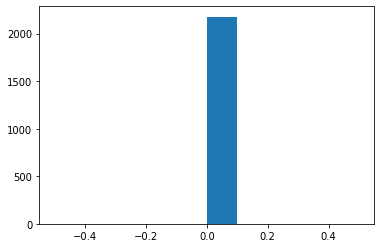

In [83]:
ssA = element_array_stepsize.copy()

plt.hist(ssA)#, bins=30)
plt.show()

### step forward a reasonable amount and iterate

In [84]:
#prepare for video
frameno = 1
time_between_observations = 0.01
time_end_recording = tB
time_of_next_observation = tme + time_between_observations

#ready... get set... GO!
os.chdir(nb_dir)
os.chdir(save_folder_vid)

while time_of_next_observation <= time_end_recording:
    tf = time_of_next_observation
    #integrate forward to the next time of observation
    #     integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                              element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_implicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #         
    #     integrate_system_explicit_asynchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                              element_array_index, vertices, velocities, node_array_mass, element_array_inverse_equilibrium_position, atol_x, atol_v, btol_x, btol_v, learning_rate)
    #     integrate_system(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                              element_array_index, vertices, velocities, node_array_mass, element_array_inverse_equilibrium_position, atol_x, atol_v, btol_x, btol_v, learning_rate)
    #     integrate_system_dormand_prince_asynchronous(tf,element_array_time,element_array_stepsize,node_array_time,element_array_index,vertices,velocities)
    integrate_system_dormand_prince_asynchronous(tf,element_array_time,element_array_stepsize,node_array_time,element_array_index,vertices,velocities,node_array_mass,element_array_inverse_equilibrium_position,element_array_mass)

    #update a copy of all positions to the observation time using the current velocity
    x = vertices.copy()
    for a in range(N_vertices):
        x[a] += velocities[a] * (tf - tau[a])
    
    #measure observables
    ##mesh measures
    net_volume = compute_net_volume(x, element_array_index)
    net_energy = compute_net_energy(N_elements, element_array_mass, velocities, x, #vertices,
                                  element_array_index, element_array_inverse_equilibrium_position, mu, lam)
    ##stepsize measures
    stepsize_mean = np.mean(element_array_stepsize)
    stepsize_std = np.std(element_array_stepsize)
    stepsize_median = np.median(element_array_stepsize)

    #record observables
    volume_lst.append(net_volume)
    energy_lst.append(net_energy)
    tme = tf
    tme_lst.append(tme)
    stepsize_mean_lst.append(stepsize_mean)
    stepsize_std_lst.append(stepsize_std)
    stepsize_median_lst.append(stepsize_median)
    stepsize_count_lst.append(count_array(array = element_array_stepsize,bins=learning_bins))
    #record image of system
#     try:
#         img = get_img_of_system(vertices, input_file_name, darkmode = False, text=f'time={tf:.2f}')
#     except:
#         pass
#     save_fn_img = f'img{frameno:09}.png'
#     frameno += 1
#     Img = Image.fromarray(img)
# #     Img.save(save_fn_img)


#     del Img
    #increment time_of_next_observation
    time_of_next_observation += time_between_observations
    #TODO(later): do something that makes a boring video less boring
    #TODO(later): def element_array_count_calls_one_step to the call of integrate_system_.... i.e. Keep track of how many times each element is called to time step
    #TODO(later): keep track of how many times each element config is updated with element_array_count_config_updates
print(stepsize_mean, stepsize_std, stepsize_median)
# beep(3)

/Users/timothytyree/Documents/GitHub/avi/nb/lib/controller/integrate_forward_dormand_prince_asynchronous.py:101: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  max_err, mav_err, x_out,v_out,x_err,v_err = one_step_explicit_dormand_prince_method(h,x,v,K_masses,K_tau,tau_of_K,Bm)


LinAlgError: Matrix is singular to machine precision.

In [ ]:
ssB = element_array_stepsize.copy()

plt.hist(ssB)#, bins=30)
plt.show()

In [ ]:
#prepare for video
frameno = 1
time_between_observations = 0.01
time_end_recording = tC
time_of_next_observation = tme + time_between_observations

#ready... get set... GO!
os.chdir(nb_dir)
os.chdir(save_folder_vid)

while time_of_next_observation <= time_end_recording:
    tf = time_of_next_observation
    #integrate forward to the next time of observation
#     integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
#                                              element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_implicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_dormand_prince_asynchronous(tf,element_array_time,element_array_stepsize,node_array_time,element_array_index,vertices,velocities,
    #         node_array_mass,element_array_inverse_equilibrium_position,element_array_mass)
#     integrate_system_explicit_asynchronous(tf, element_array_time, element_array_stepsize, node_array_time,element_array_index, vertices, velocities, node_array_mass, element_array_inverse_equilibrium_position, atol_x, atol_v, btol_x, btol_v, learning_rate)
    integrate_system_dormand_prince_asynchronous(tf,element_array_time,element_array_stepsize,node_array_time,element_array_index,vertices,velocities,node_array_mass,element_array_inverse_equilibrium_position,element_array_mass)

    #update a copy of all positions to the observation time using the current velocity
    x = vertices.copy()
    for a in range(N_vertices):
        x[a] += velocities[a] * (tf - tau[a])
    
    #measure observables
    ##mesh measures
    net_volume = compute_net_volume(x, element_array_index)
    net_energy = compute_net_energy(N_elements, element_array_mass, velocities, x, #vertices,
                                  element_array_index, element_array_inverse_equilibrium_position, mu, lam)
    ##stepsize measures
    stepsize_mean = np.mean(element_array_stepsize)
    stepsize_std = np.std(element_array_stepsize)
    stepsize_median = np.median(element_array_stepsize)

    #record observables
    volume_lst.append(net_volume)
    energy_lst.append(net_energy)
    tme = tf
    tme_lst.append(tme)
    stepsize_mean_lst.append(stepsize_mean)
    stepsize_std_lst.append(stepsize_std)
    stepsize_median_lst.append(stepsize_median)
    stepsize_count_lst.append(count_array(array = element_array_stepsize,bins=learning_bins))
    #record image of system
#     try:
#         img = get_img_of_system(vertices, input_file_name, darkmode = False, text=f'time={tf:.2f}')
#     except:
#         pass
#     save_fn_img = f'img{frameno:09}.png'
#     frameno += 1
#     Img = Image.fromarray(img)
# #     Img.save(save_fn_img)


#     del Img
    #increment time_of_next_observation
    time_of_next_observation += time_between_observations
    #TODO(later): do something that makes a boring video less boring
    #TODO(later): def element_array_count_calls_one_step to the call of integrate_system_.... i.e. Keep track of how many times each element is called to time step
    #TODO(later): keep track of how many times each element config is updated with element_array_count_config_updates
print(stepsize_mean, stepsize_std, stepsize_median)
# beep(3)

In [ ]:
tme

In [ ]:
ssC = element_array_stepsize.copy()

plt.hist(ssC)#, bins=30)
plt.show()

In [ ]:
#prepare for video
frameno = 1
time_between_observations = 0.01
time_end_recording = tD
time_of_next_observation = tme + time_between_observations

#ready... get set... GO!
os.chdir(nb_dir)
os.chdir(save_folder_vid)

while time_of_next_observation <= time_end_recording:
    tf = time_of_next_observation
    #integrate forward to the next time of observation
#     integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
#                                              element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_implicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_dormand_prince_asynchronous(tf,element_array_time,element_array_stepsize,node_array_time,element_array_index,vertices,velocities,
    #         node_array_mass,element_array_inverse_equilibrium_position,element_array_mass)
#     integrate_system_explicit_asynchronous(tf, element_array_time, element_array_stepsize, node_array_time,element_array_index, vertices, velocities, node_array_mass, element_array_inverse_equilibrium_position, atol_x, atol_v, btol_x, btol_v, learning_rate)
    integrate_system_dormand_prince_asynchronous(tf,element_array_time,element_array_stepsize,node_array_time,element_array_index,vertices,velocities,node_array_mass,element_array_inverse_equilibrium_position,element_array_mass)

    #update a copy of all positions to the observation time using the current velocity
    x = vertices.copy()
    for a in range(N_vertices):
        x[a] += velocities[a] * (tf - tau[a])
    
    #measure observables
    ##mesh measures
    net_volume = compute_net_volume(x, element_array_index)
    net_energy = compute_net_energy(N_elements, element_array_mass, velocities, x, #vertices,
                                  element_array_index, element_array_inverse_equilibrium_position, mu, lam)
    ##stepsize measures
    stepsize_mean = np.mean(element_array_stepsize)
    stepsize_std = np.std(element_array_stepsize)
    stepsize_median = np.median(element_array_stepsize)

    #record observables
    volume_lst.append(net_volume)
    energy_lst.append(net_energy)
    tme = tf
    tme_lst.append(tme)
    stepsize_mean_lst.append(stepsize_mean)
    stepsize_std_lst.append(stepsize_std)
    stepsize_median_lst.append(stepsize_median)
    stepsize_count_lst.append(count_array(array = element_array_stepsize,bins=learning_bins))
    #record image of system
#     try:
#         img = get_img_of_system(vertices, input_file_name, darkmode = False, text=f'time={tf:.2f}')
#     except:
#         pass
#     save_fn_img = f'img{frameno:09}.png'
#     frameno += 1
#     Img = Image.fromarray(img)
# #     Img.save(save_fn_img)


#     del Img
    #increment time_of_next_observation
    time_of_next_observation += time_between_observations
    #TODO(later): do something that makes a boring video less boring
    #TODO(later): def element_array_count_calls_one_step to the call of integrate_system_.... i.e. Keep track of how many times each element is called to time step
    #TODO(later): keep track of how many times each element config is updated with element_array_count_config_updates
print(stepsize_mean, stepsize_std, stepsize_median)
# beep(3)

In [ ]:
tme

In [ ]:
ssD = element_array_stepsize.copy()

plt.hist(ssD, bins=10)
plt.show()

In [ ]:
#prepare for video
frameno = 1
time_between_observations = 0.01
time_end_recording = tE
time_of_next_observation = tme + time_between_observations

#ready... get set... GO!
os.chdir(nb_dir)
os.chdir(save_folder_vid)

while time_of_next_observation <= time_end_recording:
    tf = time_of_next_observation
    #integrate forward to the next time of observation
#     integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
#                                              element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_implicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_dormand_prince_asynchronous(tf,element_array_time,element_array_stepsize,node_array_time,element_array_index,vertices,velocities,
    #         node_array_mass,element_array_inverse_equilibrium_position,element_array_mass)
#     integrate_system_explicit_asynchronous(tf, element_array_time, element_array_stepsize, node_array_time, element_array_index, vertices, velocities, node_array_mass, element_array_inverse_equilibrium_position, atol_x, atol_v, btol_x, btol_v, learning_rate)
    integrate_system_dormand_prince_asynchronous(tf,element_array_time,element_array_stepsize,node_array_time,element_array_index,vertices,velocities,node_array_mass,element_array_inverse_equilibrium_position,element_array_mass)

    #update a copy of all positions to the observation time using the current velocity
    x = vertices.copy()
    for a in range(N_vertices):
        x[a] += velocities[a] * (tf - tau[a])
    
    #measure observables
    ##mesh measures
    net_volume = compute_net_volume(x, element_array_index)
    net_energy = compute_net_energy(N_elements, element_array_mass, velocities, x, #vertices,
                                  element_array_index, element_array_inverse_equilibrium_position, mu, lam)
    ##stepsize measures
    stepsize_mean = np.mean(element_array_stepsize)
    stepsize_std = np.std(element_array_stepsize)
    stepsize_median = np.median(element_array_stepsize)

    #record observables
    volume_lst.append(net_volume)
    energy_lst.append(net_energy)
    tme = tf
    tme_lst.append(tme)
    stepsize_mean_lst.append(stepsize_mean)
    stepsize_std_lst.append(stepsize_std)
    stepsize_median_lst.append(stepsize_median)
    stepsize_count_lst.append(count_array(array = element_array_stepsize,bins=learning_bins))
    #record image of system
#     try:
#         img = get_img_of_system(vertices, input_file_name, darkmode = False, text=f'time={tf:.2f}')
#     except:
#         pass
#     save_fn_img = f'img{frameno:09}.png'
#     frameno += 1
#     Img = Image.fromarray(img)
# #     Img.save(save_fn_img)


#     del Img
    #increment time_of_next_observation
    time_of_next_observation += time_between_observations
    #TODO(later): do something that makes a boring video less boring
    #TODO(later): def element_array_count_calls_one_step to the call of integrate_system_.... i.e. Keep track of how many times each element is called to time step
    #TODO(later): keep track of how many times each element config is updated with element_array_count_config_updates
print(stepsize_mean, stepsize_std, stepsize_median)
# beep(3)

In [ ]:
ssE = element_array_stepsize.copy()

plt.hist(ssE, bins=10)
plt.show()

In [ ]:
#prepare for video
frameno = 1
time_between_observations = 0.01
time_end_recording = tF
time_of_next_observation = tme + time_between_observations

#ready... get set... GO!
os.chdir(nb_dir)
os.chdir(save_folder_vid)

while time_of_next_observation <= time_end_recording:
    tf = time_of_next_observation
    #integrate forward to the next time of observation
#     integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
#                                              element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_implicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_dormand_prince_asynchronous(tf,element_array_time,element_array_stepsize,node_array_time,element_array_index,vertices,velocities,
    #         node_array_mass,element_array_inverse_equilibrium_position,element_array_mass)
#     integrate_system_explicit_asynchronous(tf, element_array_time, element_array_stepsize, node_array_time,element_array_index, vertices, velocities, node_array_mass, element_array_inverse_equilibrium_position, atol_x, atol_v, btol_x, btol_v, learning_rate)
    integrate_system_dormand_prince_asynchronous(tf,element_array_time,element_array_stepsize,node_array_time,element_array_index,vertices,velocities,node_array_mass,element_array_inverse_equilibrium_position,element_array_mass)

    #update a copy of all positions to the observation time using the current velocity
    x = vertices.copy()
    for a in range(N_vertices):
        x[a] += velocities[a] * (tf - tau[a])
    
    #measure observables
    ##mesh measures
    net_volume = compute_net_volume(x, element_array_index)
    net_energy = compute_net_energy(N_elements, element_array_mass, velocities, x, #vertices,
                                  element_array_index, element_array_inverse_equilibrium_position, mu, lam)
    ##stepsize measures
    stepsize_mean = np.mean(element_array_stepsize)
    stepsize_std = np.std(element_array_stepsize)
    stepsize_median = np.median(element_array_stepsize)

    #record observables
    volume_lst.append(net_volume)
    energy_lst.append(net_energy)
    tme = tf
    tme_lst.append(tme)
    stepsize_mean_lst.append(stepsize_mean)
    stepsize_std_lst.append(stepsize_std)
    stepsize_median_lst.append(stepsize_median)
    stepsize_count_lst.append(count_array(array = element_array_stepsize,bins=learning_bins))
    #record image of system
#     try:
#         img = get_img_of_system(vertices, input_file_name, darkmode = False, text=f'time={tf:.2f}')
#     except:
#         pass
#     save_fn_img = f'img{frameno:09}.png'
#     frameno += 1
#     Img = Image.fromarray(img)
# #     Img.save(save_fn_img)


#     del Img
    #increment time_of_next_observation
    time_of_next_observation += time_between_observations
    #TODO(later): do something that makes a boring video less boring
    #TODO(later): def element_array_count_calls_one_step to the call of integrate_system_.... i.e. Keep track of how many times each element is called to time step
    #TODO(later): keep track of how many times each element config is updated with element_array_count_config_updates
print(stepsize_mean, stepsize_std, stepsize_median)
# beep(3)

In [ ]:
ssF = element_array_stepsize.copy()

plt.hist(ssF, bins=10)
plt.show()

In [ ]:
#prepare for video
frameno = 1
time_between_observations = 0.01
time_end_recording = tG
time_of_next_observation = tme + time_between_observations

#ready... get set... GO!
os.chdir(nb_dir)
os.chdir(save_folder_vid)

while time_of_next_observation <= time_end_recording:
    tf = time_of_next_observation
    #integrate forward to the next time of observation
#     integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
#                                              element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_implicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_dormand_prince_asynchronous(tf,element_array_time,element_array_stepsize,node_array_time,element_array_index,vertices,velocities,
    #         node_array_mass,element_array_inverse_equilibrium_position,element_array_mass)
#     integrate_system_explicit_asynchronous(tf, element_array_time, element_array_stepsize, node_array_time, element_array_index, vertices, velocities, node_array_mass, element_array_inverse_equilibrium_position, atol_x, atol_v, btol_x, btol_v, learning_rate)
    integrate_system_dormand_prince_asynchronous(tf,element_array_time,element_array_stepsize,node_array_time,element_array_index,vertices,velocities,node_array_mass,element_array_inverse_equilibrium_position,element_array_mass)

    #update a copy of all positions to the observation time using the current velocity
    x = vertices.copy()
    for a in range(N_vertices):
        x[a] += velocities[a] * (tf - tau[a])
    
    #measure observables
    ##mesh measures
    net_volume = compute_net_volume(x, element_array_index)
    net_energy = compute_net_energy(N_elements, element_array_mass, velocities, x, #vertices,
                                  element_array_index, element_array_inverse_equilibrium_position, mu, lam)
    ##stepsize measures
    stepsize_mean = np.mean(element_array_stepsize)
    stepsize_std = np.std(element_array_stepsize)
    stepsize_median = np.median(element_array_stepsize)

    #record observables
    volume_lst.append(net_volume)
    energy_lst.append(net_energy)
    tme = tf
    tme_lst.append(tme)
    stepsize_mean_lst.append(stepsize_mean)
    stepsize_std_lst.append(stepsize_std)
    stepsize_median_lst.append(stepsize_median)
    stepsize_count_lst.append(count_array(array = element_array_stepsize,bins=learning_bins))
    #record image of system
#     try:
#         img = get_img_of_system(vertices, input_file_name, darkmode = False, text=f'time={tf:.2f}')
#     except:
#         pass
#     save_fn_img = f'img{frameno:09}.png'
#     frameno += 1
#     Img = Image.fromarray(img)
# #     Img.save(save_fn_img)


#     del Img
    #increment time_of_next_observation
    time_of_next_observation += time_between_observations
    #TODO(later): do something that makes a boring video less boring
    #TODO(later): def element_array_count_calls_one_step to the call of integrate_system_.... i.e. Keep track of how many times each element is called to time step
    #TODO(later): keep track of how many times each element config is updated with element_array_count_config_updates
print(stepsize_mean, stepsize_std, stepsize_median)
# beep(3)

In [ ]:
ssG = element_array_stepsize.copy()

plt.hist(ssG, bins=10)
plt.show()

In [ ]:
#prepare for video
frameno = 1
time_between_observations = 0.01
time_end_recording = tH
time_of_next_observation = tme + time_between_observations

#ready... get set... GO!
os.chdir(nb_dir)
os.chdir(save_folder_vid)

while time_of_next_observation <= time_end_recording:
    tf = time_of_next_observation
    #integrate forward to the next time of observation
#     integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
#                                              element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_implicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_dormand_prince_asynchronous(tf,element_array_time,element_array_stepsize,node_array_time,element_array_index,vertices,velocities,
    #         node_array_mass,element_array_inverse_equilibrium_position,element_array_mass)
#     integrate_system_explicit_asynchronous(tf, element_array_time, element_array_stepsize, node_array_time,element_array_index, vertices, velocities, node_array_mass, element_array_inverse_equilibrium_position, atol_x, atol_v, btol_x, btol_v, learning_rate)
    integrate_system_dormand_prince_asynchronous(tf,element_array_time,element_array_stepsize,node_array_time,element_array_index,vertices,velocities,node_array_mass,element_array_inverse_equilibrium_position,element_array_mass)

    #update a copy of all positions to the observation time using the current velocity
    x = vertices.copy()
    for a in range(N_vertices):
        x[a] += velocities[a] * (tf - tau[a])
    
    #measure observables
    ##mesh measures
    net_volume = compute_net_volume(x, element_array_index)
    net_energy = compute_net_energy(N_elements, element_array_mass, velocities, x, #vertices,
                                  element_array_index, element_array_inverse_equilibrium_position, mu, lam)
    ##stepsize measures
    stepsize_mean = np.mean(element_array_stepsize)
    stepsize_std = np.std(element_array_stepsize)
    stepsize_median = np.median(element_array_stepsize)

    #record observables
    volume_lst.append(net_volume)
    energy_lst.append(net_energy)
    tme = tf
    tme_lst.append(tme)
    stepsize_mean_lst.append(stepsize_mean)
    stepsize_std_lst.append(stepsize_std)
    stepsize_median_lst.append(stepsize_median)
    stepsize_count_lst.append(count_array(array = element_array_stepsize,bins=learning_bins))
    #record image of system
#     try:
#         img = get_img_of_system(vertices, input_file_name, darkmode = False, text=f'time={tf:.2f}')
#     except:
#         pass
#     save_fn_img = f'img{frameno:09}.png'
#     frameno += 1
#     Img = Image.fromarray(img)
# #     Img.save(save_fn_img)


#     del Img
    #increment time_of_next_observation
    time_of_next_observation += time_between_observations
    #TODO(later): do something that makes a boring video less boring
    #TODO(later): def element_array_count_calls_one_step to the call of integrate_system_.... i.e. Keep track of how many times each element is called to time step
    #TODO(later): keep track of how many times each element config is updated with element_array_count_config_updates
print(stepsize_mean, stepsize_std, stepsize_median)
beep(1)

In [ ]:
ssH = element_array_stepsize.copy()

plt.hist(ssH, bins=10)
plt.show()

# plot up these histograms

In [ ]:
fig, axs = plt.subplots(figsize = (9,4), ncols = 2)
ax = axs[0]
bins = 30
axkwargs = {
    'fontsize':14,
    
}
hkwargs = {
    'color':'blue',#'orange',
    'cumulative':False,
    'stacked':True,
    'log':False,
    'density':False,
    'bins':bins
}
# _bins,_,_ = 
ax.set_xlim([0,np.max(ssF)])
ax.hist(ssA, alpha=0.05, label = f't={tA}', **hkwargs)#, color='Blues', c=1)
# kwargs['bins']=_bins
ax.hist(ssB, alpha=0.1, label = f't={tB}', **hkwargs)
ax.hist(ssC, alpha=0.2, label = f't={tC}', **hkwargs)
ax.hist(ssD, alpha=0.3, label = f't={tD}', **hkwargs)
ax.hist(ssE, alpha=.7, label = f't={tE}', **hkwargs)
# ax.hist(ssF, bins=bins, **hkwargs)
# ax.hist(ssG, bins=bins, **hkwargs)
# ax.hist(ssH, bins=bins, **hkwargs)
ax.legend(**axkwargs)
plt.xticks(**axkwargs)

ax.set_ylim([0,3500])
ax.set_ylabel('frequency',**axkwargs)
ax.set_xlabel('step size',**axkwargs)
ax.tick_params(labelsize=axkwargs['fontsize'])
# ax.set_xticklabels(xlabels, Fontsize= )
# ax.set_xticklabels(ax.get_xticklabels(),**axkwargs)

ax = axs[1]
x_values = np.array(tme_lst)
y_values = np.array(stepsize_mean_lst)
ax.plot(x_values, y_values)
ax.fill_between(x_values, y_values-stepsize_std_lst,y_values+stepsize_std_lst, alpha=0.2)
ax.set_xlabel('time',**axkwargs)
ax.set_ylabel('average step size',**axkwargs)
# plt.xticks(**axkwargs)
ax.tick_params(labelsize=axkwargs['fontsize'])

plt.tight_layout()
plt.show()


In [ ]:
np.cumsum(ssA)/N_elements

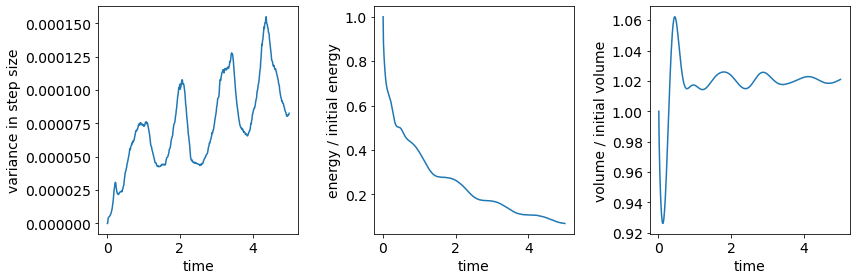

In [104]:
fig, axs = plt.subplots(figsize = (12,4), ncols = 3)

ax = axs[0]
x_values = np.array(tme_lst)
y_values = np.array([s**2 for s in stepsize_std_lst])
ax.plot(x_values, y_values)
# ax.fill_between(x_values, y_values-stepsize_std_lst,y_values+stepsize_std_lst, alpha=0.2)
ax.set_xlabel('time',**axkwargs)
ax.set_ylabel('variance in step size',**axkwargs)
ax.tick_params(labelsize=axkwargs['fontsize'])

#mean is not equal to variance
# ax = axs[1]
# x_values = np.array(tme_lst)
# y_values = np.array([s**2/m for s,m in zip(stepsize_std_lst,stepsize_mean_lst)])
# ax.plot(x_values, y_values)
# # ax.fill_between(x_values, y_values-stepsize_std_lst,y_values+stepsize_std_lst, alpha=0.2)
# ax.set_xlabel('time',**axkwargs)
# ax.set_ylabel('average step size',**axkwargs)


ax = axs[1]
x_values = np.array(tme_lst)
y_values = np.array(energy_lst)/energy_lst[0]#[s**2/m for s,m in zip(stepsize_std_lst,stepsize_mean_lst)])
ax.plot(x_values, y_values)
# ax.fill_between(x_values, y_values-stepsize_std_lst,y_values+stepsize_std_lst, alpha=0.2)
ax.set_xlabel('time',**axkwargs)
ax.set_ylabel('energy / initial energy',**axkwargs)
ax.tick_params(labelsize=axkwargs['fontsize'])


ax = axs[2]
x_values = np.array(tme_lst)
y_values = np.array(volume_lst)/volume_lst[0]#[s**2/m for s,m in zip(stepsize_std_lst,stepsize_mean_lst)])
ax.plot(x_values, y_values)
# ax.fill_between(x_values, y_values-stepsize_std_lst,y_values+stepsize_std_lst, alpha=0.2)
ax.set_xlabel('time',**axkwargs)
ax.set_ylabel('volume / initial volume',**axkwargs)
ax.tick_params(labelsize=axkwargs['fontsize'])

plt.tight_layout()
plt.show()

# save csv
TODO: now plot a comparable distribution from a neural set

In [105]:
df = pd.DataFrame({
    't':tme_lst,
    'volume':volume_lst,
    'energy':energy_lst,
    'stepsize_mean':stepsize_mean_lst,
    'stepsize_std':stepsize_std_lst,
    'stepsize_median':stepsize_median_lst,
})

In [106]:
os.chdir(data_folder)
df.to_csv(data_fn, index=False)

In [107]:
# retval = !ls
# print (retval ) 
beep(5)

0

# 

In [108]:
ls -l

total 3864
-rw-r--r--  1 timothytyree  staff   69728 Dec 10 17:00 avi_es_counts_fixed_lr_a_equal_b_spherical_mesh_100_mu_1.0_lambda_10.0_gamma_0.0_vscale_1.0_stepsizeinit_0.0001_salience_2_atolx_0.0001.npy
-rw-r--r--  1 timothytyree  staff      22 Dec  9 18:33 avi_es_counts_spherical_mesh_100_mu_1.0_lambda_10.0_gamma_0.0.npy.npz
-rw-r--r--  1 timothytyree  staff   60145 Dec 10 21:55 avi_es_fixed_lr_a_equal_b_spherical_mesh_1000_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.005_salience_2_atolx_0.0001.csv
-rw-r--r--  1 timothytyree  staff   35726 Dec 10 17:00 avi_es_fixed_lr_a_equal_b_spherical_mesh_100_mu_1.0_lambda_10.0_gamma_0.0_vscale_1.0_stepsizeinit_0.0001_salience_2_atolx_0.0001.csv
-rw-r--r--  1 timothytyree  staff   18587 Dec 10 15:25 avi_es_fixed_lr_a_equal_b_spherical_mesh_100_mu_1.0_lambda_10.0_gamma_0.0_vscale_2.0_stepsizeinit_0.0001_salience_2_atolx_0.0001.csv
-rw-r--r--  1 timothytyree  staff   35900 Dec 10 21:04 avi_es_fixed_lr_a_equal_b_spherical_mesh_400_mu_1

# make a function that generates a given input kwargs

In [ ]:
kwargs= {
'mu' = 1., 
'lam' = 10.,
'gamma' = .05,#1.#1.;
'salience' = 2,#128#32
'lasso_fraction' = 0.5,
'v_scale' = 2.,
'mass_density'=1.,
'stepsize_init' = 0.002,#0.005#0.00001#0.0001
'atol_x' = 0.00001,#0.001#1e-7; 
'atol_v' = 0.00001,#0.001#1e-7; 
'btol_x' = 0.000001,#0.001#1e-10; 
'btol_v' = 0.000001,#0.001#1e-10; 
'mesh_size' = 64,
}


def generate_timeseries(**kwargs):
    learning_rate = np.log(salience)
    #path to mesh
    input_file_name = f'../data/spherical_meshes/spherical_mesh_{mesh_size}.stl'
    # input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'

    # input_file_name = f'../data/spherical_meshes/spherical_mesh_400.stl'
    #where to save results
    data_folder =  os.path.join(nb_dir,'../data/mov_csv')
    data_fn = f"avi_es_fixed_lr_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}_vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
    # data_fn = f"avi_ns_fixed_lr_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
    save_folder_vid = '../vid/tmp'
    folder_vid = '../vid'
    # data_fn_counts = data_fn.replace("s_","s_counts_").replace('.csv','.npz')
    data_fn_counts = data_fn.replace("s_","s_counts_").replace('.csv','.npy')

    os.chdir(nb_dir)
    # input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'
    # input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'
    input_file_name = os.path.join(nb_dir,input_file_name)
    tme = 0.
    dict_values_system = initialize_system(input_file_name, time_initial=tme, mass_density=mass_density)
    locals().update(dict_values_system)
    N_elements = element_array_index.shape[0]
    N_vertices = node_array_position.shape[0]
    print(list(dict_values_system.keys()))


    integrate_system_explicit_asynchronous = get_integrate_system_explicit_asynchronous(mu,lam,gamma)



    #initialize system
    tauK = element_array_time
    tau = node_array_time

    #get method of computing elastic forces 
    zero_mat = np.zeros((4,3))
    # calc_P = get_calc_P(mu, lam)
    # compute_nodal_damping_forces  = get_compute_nodal_damping_forces(mu,lam,gamma)
    # comp_nodal_elastic_forces = get_comp_nodal_elastic_forces(mu, lam)

    elements = element_array_index
    vertices = node_array_position

    #initialize stepsizes of simulation
    element_array_stepsize = np.zeros_like(element_array_time) + stepsize_init
    element_array_count_calls_one_step = np.zeros_like(element_array_time,dtype=int)
    element_array_count_config_updates = np.zeros_like(element_array_time,dtype=int)
    momentum = node_array_momentum.copy()
    velocities = momentum.copy()
    for j in range(N_vertices):
        velocities[j] /= node_array_mass[j]


    # #perturb momentum in the x direction and let it run overnight with a small timestep  
    velocities[:,0] = -v_scale * vertices[:,0].copy()

    #initialize containers of measures
    volume_lst = []
    energy_lst = []
    tme_lst    = []
    stepsize_mean_lst   = []
    stepsize_std_lst    = []
    stepsize_median_lst = []
    stepsize_count_lst = []
    frac_lb = lambda i: np.exp(learning_rate*i)  ##np.exp((i+.5)*learning_rate/10)
    learning_bins = np.array([stepsize_init*frac_lb(i) for i in np.arange(-15,15)])

    # #this looks nice. 30 bins
    # learning_bins = np.array([0.00480198, 0.00480886, 0.00481574, 0.00482262, 0.00482951,
    #         0.00483639, 0.00484327, 0.00485015, 0.00485703, 0.00486391,
    #         0.0048708 , 0.00487768, 0.00488456, 0.00489144, 0.00489832,
    #         0.0049052 , 0.00491209, 0.00491897, 0.00492585, 0.00493273,
    #         0.00493961, 0.00494649, 0.00495338, 0.00496026, 0.00496714,
    #         0.00497402, 0.0049809 , 0.00498778, 0.00499467, 0.00500155,
    #         0.00500843])

    # #let's try 100 bins
    # learning_bins = np.array([0.00477609, 0.00477838, 0.00478067, 0.00478296, 0.00478526,
    #         0.00478755, 0.00478984, 0.00479214, 0.00479443, 0.00479672,
    #         0.00479902, 0.00480131, 0.0048036 , 0.0048059 , 0.00480819,
    #         0.00481048, 0.00481277, 0.00481507, 0.00481736, 0.00481965,
    #         0.00482195, 0.00482424, 0.00482653, 0.00482883, 0.00483112,
    #         0.00483341, 0.00483571, 0.004838  , 0.00484029, 0.00484258,
    #         0.00484488, 0.00484717, 0.00484946, 0.00485176, 0.00485405,
    #         0.00485634, 0.00485864, 0.00486093, 0.00486322, 0.00486552,
    #         0.00486781, 0.0048701 , 0.0048724 , 0.00487469, 0.00487698,
    #         0.00487927, 0.00488157, 0.00488386, 0.00488615, 0.00488845,
    #         0.00489074, 0.00489303, 0.00489533, 0.00489762, 0.00489991,
    #         0.00490221, 0.0049045 , 0.00490679, 0.00490908, 0.00491138,
    #         0.00491367, 0.00491596, 0.00491826, 0.00492055, 0.00492284,
    #         0.00492514, 0.00492743, 0.00492972, 0.00493202, 0.00493431,
    #         0.0049366 , 0.0049389 , 0.00494119, 0.00494348, 0.00494577,
    #         0.00494807, 0.00495036, 0.00495265, 0.00495495, 0.00495724,
    #         0.00495953, 0.00496183, 0.00496412, 0.00496641, 0.00496871,
    #         0.004971  , 0.00497329, 0.00497558, 0.00497788, 0.00498017,
    #         0.00498246, 0.00498476, 0.00498705, 0.00498934, 0.00499164,
    #         0.00499393, 0.00499622, 0.00499852, 0.00500081, 0.0050031 ,
    #         0.00500539])

    # learning_bins = np.array([stepsize_init*np.exp((i+.5)*learning_rate) for i in np.arange(-3,3)])
    print(f"learning_bins are {learning_bins}")



    #prepare for video
    frameno = 1
    time_between_observations = 0.01
    time_end_recording = tB
    time_of_next_observation = tme + time_between_observations

    #ready... get set... GO!
    os.chdir(nb_dir)
    os.chdir(save_folder_vid)

    while time_of_next_observation <= time_end_recording:
        tf = time_of_next_observation
        #integrate forward to the next time of observation
    #     integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                              element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
        #     integrate_system_implicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
        #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
        #     integrate_system_dormand_prince_asynchronous(tf,element_array_time,element_array_stepsize,node_array_time,element_array_index,vertices,velocities,
        #         node_array_mass,element_array_inverse_equilibrium_position,element_array_mass)
        integrate_system_explicit_asynchronous(tf, element_array_time, element_array_stepsize, node_array_time,
                                                 element_array_index, vertices, velocities, node_array_mass, element_array_inverse_equilibrium_position, atol_x, atol_v, btol_x, btol_v, learning_rate)

        #update a copy of all positions to the observation time using the current velocity
        x = vertices.copy()
        for a in range(N_vertices):
            x[a] += velocities[a] * (tf - tau[a])

        #measure observables
        ##mesh measures
        net_volume = compute_net_volume(x, element_array_index)
        net_energy = compute_net_energy(N_elements, element_array_mass, velocities, x, #vertices,
                                      element_array_index, element_array_inverse_equilibrium_position, mu, lam)
        ##stepsize measures
        stepsize_mean = np.mean(element_array_stepsize)
        stepsize_std = np.std(element_array_stepsize)
        stepsize_median = np.median(element_array_stepsize)

        #record observables
        volume_lst.append(net_volume)
        energy_lst.append(net_energy)
        tme = tf
        tme_lst.append(tme)
        stepsize_mean_lst.append(stepsize_mean)
        stepsize_std_lst.append(stepsize_std)
        stepsize_median_lst.append(stepsize_median)
        stepsize_count_lst.append(count_array(array = element_array_stepsize,bins=learning_bins))
        #record image of system
    #     try:
    #         img = get_img_of_system(vertices, input_file_name, darkmode = False, text=f'time={tf:.2f}')
    #     except:
    #         pass
    #     save_fn_img = f'img{frameno:09}.png'
    #     frameno += 1
    #     Img = Image.fromarray(img)
    # #     Img.save(save_fn_img)


    #     del Img
        #increment time_of_next_observation
        time_of_next_observation += time_between_observations
        #TODO(later): do something that makes a boring video less boring
        #TODO(later): def element_array_count_calls_one_step to the call of integrate_system_.... i.e. Keep track of how many times each element is called to time step
        #TODO(later): keep track of how many times each element config is updated with element_array_count_config_updates
    print(stepsize_mean, stepsize_std, stepsize_median)
    # beep(3)


    df = pd.DataFrame({
        't':tme_lst,
        'volume':volume_lst,
        'energy':energy_lst,
        'stepsize_mean':stepsize_mean_lst,
        'stepsize_std':stepsize_std_lst,
        'stepsize_median':stepsize_median_lst,
    })


    os.chdir(data_folder)
    df.to_csv(data_fn, index=False)
    return data_fn

In [139]:
kwargs= {
'' = 1., 
'' = 10.,
'' = .05,#1.#1.;
'' = 2,#128#32
'' = 0.5,
'' = 2.,
''=1.,
'' = 0.002,#0.005#0.00001#0.0001
'' = 0.00001,#0.001#1e-7; 
'' = 0.00001,#0.001#1e-7; 
'' = 0.000001,#0.001#1e-10; 
'' = 0.000001,#0.001#1e-10; 
'' = 64,
}

SyntaxError: invalid syntax (<ipython-input-139-2123e3536bf4>, line 2)

In [148]:
def generate_timeseries(mu,lam,gamma,salience,lasso_fraction,v_scale,mass_density,stepsize_init,atol_x,atol_v,btol_x,btol_v,mesh_size,tmax,**kwargs):

    learning_rate = np.log(salience)
    #path to mesh
    input_file_name = f'../data/spherical_meshes/spherical_mesh_{mesh_size}.stl'
    # input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'

    # input_file_name = f'../data/spherical_meshes/spherical_mesh_400.stl'
    #where to save results
    data_folder =  os.path.join(nb_dir,'../data/mov_csv')
    data_fn = f"avi_es_fixed_lr_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}_vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
    # data_fn = f"avi_ns_fixed_lr_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
    save_folder_vid = '../vid/tmp'
    folder_vid = '../vid'
    # data_fn_counts = data_fn.replace("s_","s_counts_").replace('.csv','.npz')
    data_fn_counts = data_fn.replace("s_","s_counts_").replace('.csv','.npy')

    os.chdir(nb_dir)
    # input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'
    # input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'
    input_file_name = os.path.join(nb_dir,input_file_name)
    tme = 0.
    dict_values_system = initialize_system(input_file_name, time_initial=tme, mass_density=mass_density)
    locals().update(dict_values_system)
    N_elements = element_array_index.shape[0]
    N_vertices = node_array_position.shape[0]
    print(list(dict_values_system.keys()))


    integrate_system_explicit_asynchronous = get_integrate_system_explicit_asynchronous(mu,lam,gamma)



    #initialize system
    tauK = element_array_time
    tau = node_array_time

    #get method of computing elastic forces 
    zero_mat = np.zeros((4,3))
    # calc_P = get_calc_P(mu, lam)
    # compute_nodal_damping_forces  = get_compute_nodal_damping_forces(mu,lam,gamma)
    # comp_nodal_elastic_forces = get_comp_nodal_elastic_forces(mu, lam)

    elements = element_array_index
    vertices = node_array_position

    #initialize stepsizes of simulation
    element_array_stepsize = np.zeros_like(element_array_time) + stepsize_init
    element_array_count_calls_one_step = np.zeros_like(element_array_time,dtype=int)
    element_array_count_config_updates = np.zeros_like(element_array_time,dtype=int)
    momentum = node_array_momentum.copy()
    velocities = momentum.copy()
    for j in range(N_vertices):
        velocities[j] /= node_array_mass[j]


    # #perturb momentum in the x direction and let it run overnight with a small timestep  
    velocities[:,0] = -v_scale * vertices[:,0].copy()

    #initialize containers of measures
    volume_lst = []
    energy_lst = []
    tme_lst    = []
    stepsize_mean_lst   = []
    stepsize_std_lst    = []
    stepsize_median_lst = []
    stepsize_count_lst = []
    frac_lb = lambda i: np.exp(learning_rate*i)  ##np.exp((i+.5)*learning_rate/10)
    learning_bins = np.array([stepsize_init*frac_lb(i) for i in np.arange(-15,15)])

    # learning_bins = np.array([stepsize_init*np.exp((i+.5)*learning_rate) for i in np.arange(-3,3)])
    print(f"learning_bins are {learning_bins}")



    #prepare for video
    frameno = 1
    time_between_observations = 0.01
    time_end_recording = tmax
    time_of_next_observation = tme + time_between_observations

    #ready... get set... GO!
    os.chdir(nb_dir)
    os.chdir(save_folder_vid)

    while time_of_next_observation <= time_end_recording:
        tf = time_of_next_observation
        #integrate forward to the next time of observation
    #     integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                              element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
        #     integrate_system_implicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
        #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
        #     integrate_system_dormand_prince_asynchronous(tf,element_array_time,element_array_stepsize,node_array_time,element_array_index,vertices,velocities,
        #         node_array_mass,element_array_inverse_equilibrium_position,element_array_mass)
        integrate_system_explicit_asynchronous(tf, element_array_time, element_array_stepsize, node_array_time,
                                                 element_array_index, vertices, velocities, node_array_mass, element_array_inverse_equilibrium_position, atol_x, atol_v, btol_x, btol_v, learning_rate)

        #update a copy of all positions to the observation time using the current velocity
        x = vertices.copy()
        for a in range(N_vertices):
            x[a] += velocities[a] * (tf - tau[a])

        #measure observables
        ##mesh measures
        net_volume = compute_net_volume(x, element_array_index)
        net_energy = compute_net_energy(N_elements, element_array_mass, velocities, x, #vertices,
                                      element_array_index, element_array_inverse_equilibrium_position, mu, lam)
        ##stepsize measures
        stepsize_mean   = np.mean(element_array_stepsize)
        stepsize_std    = np.std(element_array_stepsize)
        stepsize_median = np.median(element_array_stepsize)

        #record observables
        volume_lst.append(net_volume)
        energy_lst.append(net_energy)
        tme = tf
        tme_lst.append(tme)
        stepsize_mean_lst.append(stepsize_mean)
        stepsize_std_lst.append(stepsize_std)
        stepsize_median_lst.append(stepsize_median)
        stepsize_count_lst.append(count_array(array = element_array_stepsize,bins=learning_bins))
        #record image of system
    #     try:
    #         img = get_img_of_system(vertices, input_file_name, darkmode = False, text=f'time={tf:.2f}')
    #     except:
    #         pass
    #     save_fn_img = f'img{frameno:09}.png'
    #     frameno += 1
    #     Img = Image.fromarray(img)
    # #     Img.save(save_fn_img)


    #     del Img
        #increment time_of_next_observation
        time_of_next_observation += time_between_observations
        #TODO(later): do something that makes a boring video less boring
        #TODO(later): def element_array_count_calls_one_step to the call of integrate_system_.... i.e. Keep track of how many times each element is called to time step
        #TODO(later): keep track of how many times each element config is updated with element_array_count_config_updates
    print(stepsize_mean, stepsize_std, stepsize_median)
    # beep(3)


    df = pd.DataFrame({
        't':tme_lst,
        'volume':volume_lst,
        'energy':energy_lst,
        'stepsize_mean':stepsize_mean_lst,
        'stepsize_std':stepsize_std_lst,
        'stepsize_median':stepsize_median_lst,
    })


    os.chdir(data_folder)
    df.to_csv(data_fn, index=False)
    return data_fn

In [150]:
kwargs= {
'mu' : 1., 
'lam' : 10.,
'gamma' : .05,#1.#1.;
'salience' : 2,#128#32
'lasso_fraction' : 0.5,
'v_scale' : 2.,
'mass_density':1.,
'stepsize_init' : 0.002,#0.005#0.00001#0.0001
'atol_x' : 0.00001,#0.001#1e-7; 
'atol_v' : 0.00001,#0.001#1e-7; 
'btol_x' : 0.000001,#0.001#1e-10; 
'btol_v' : 0.000001,#0.001#1e-10; 
'mesh_size' : 64,
    'tmax':5,
}

generate_timeseries(**kwargs)
beep(1)

face_normals all zero, ignoring!


['element_array_time', 'element_array_index', 'element_array_mass', 'element_array_volume', 'element_array_inverse_equilibrium_position', 'node_array_equilibrium_position', 'node_array_time', 'node_array_position', 'node_array_momentum', 'node_array_mass', 'node_array_volume']
learning_bins are [6.10351563e-08 1.22070313e-07 2.44140625e-07 4.88281250e-07
 9.76562500e-07 1.95312500e-06 3.90625000e-06 7.81250000e-06
 1.56250000e-05 3.12500000e-05 6.25000000e-05 1.25000000e-04
 2.50000000e-04 5.00000000e-04 1.00000000e-03 2.00000000e-03
 4.00000000e-03 8.00000000e-03 1.60000000e-02 3.20000000e-02
 6.40000000e-02 1.28000000e-01 2.56000000e-01 5.12000000e-01
 1.02400000e+00 2.04800000e+00 4.09600000e+00 8.19200000e+00
 1.63840000e+01 3.27680000e+01]


/Users/timothytyree/Documents/GitHub/avi/nb/lib/controller/integrate_forward_explicit_asynchronous.py:45: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  next_stepsize, retval, madval = step_forward_and_learn_simple(K_index, t_given, node_array_time, element_array_time, vertices, velocities, element_array_index,


0.0018693155718879076 0.0003385846138635492 0.002


0

In [149]:
kwargs= {
'mu' : 2., 
'lam' : 10.,
'gamma' : .05,#1.#1.;
'salience' : 2,#128#32
'lasso_fraction' : 0.5,
'v_scale' : 2.,
'mass_density':1.,
'stepsize_init' : 0.002,#0.005#0.00001#0.0001
'atol_x' : 0.00001,#0.001#1e-7; 
'atol_v' : 0.00001,#0.001#1e-7; 
'btol_x' : 0.000001,#0.001#1e-10; 
'btol_v' : 0.000001,#0.001#1e-10; 
'mesh_size' : 64,
'tmax':5,
    'fn':
}

retval = generate_timeseries(**kwargs)
print(retval)
beep(1)

face_normals all zero, ignoring!


['element_array_time', 'element_array_index', 'element_array_mass', 'element_array_volume', 'element_array_inverse_equilibrium_position', 'node_array_equilibrium_position', 'node_array_time', 'node_array_position', 'node_array_momentum', 'node_array_mass', 'node_array_volume']
learning_bins are [6.10351563e-08 1.22070313e-07 2.44140625e-07 4.88281250e-07
 9.76562500e-07 1.95312500e-06 3.90625000e-06 7.81250000e-06
 1.56250000e-05 3.12500000e-05 6.25000000e-05 1.25000000e-04
 2.50000000e-04 5.00000000e-04 1.00000000e-03 2.00000000e-03
 4.00000000e-03 8.00000000e-03 1.60000000e-02 3.20000000e-02
 6.40000000e-02 1.28000000e-01 2.56000000e-01 5.12000000e-01
 1.02400000e+00 2.04800000e+00 4.09600000e+00 8.19200000e+00
 1.63840000e+01 3.27680000e+01]


/Users/timothytyree/Documents/GitHub/avi/nb/lib/controller/integrate_forward_explicit_asynchronous.py:45: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  next_stepsize, retval, madval = step_forward_and_learn_simple(K_index, t_given, node_array_time, element_array_time, vertices, velocities, element_array_index,


0.002341410197520011 0.0011470207400818822 0.002000000000000668
avi_es_fixed_lr_a_equal_b_spherical_mesh_64_mu_2.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.002_salience_2_atolx_1e-05.csv


0